**DEFECT DETECTION**

Load images in grayscale


In [4]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
from google.colab.patches import cv2_imshow


def load_images(reference_path, test_path):
    """Load images in grayscale."""
    ref = cv2.imread(reference_path, cv2.IMREAD_GRAYSCALE)
    test = cv2.imread(test_path, cv2.IMREAD_GRAYSCALE)
    if ref is None or test is None:
        raise FileNotFoundError("One or both images not found")
    return ref, test


Align test image to reference using ORB + Homography

In [5]:
def align_images(ref_img, test_img):
    """Align test image to reference using ORB + Homography."""
    orb = cv2.ORB_create(5000)
    kp1, des1 = orb.detectAndCompute(ref_img, None)
    kp2, des2 = orb.detectAndCompute(test_img, None)

    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = sorted(matcher.match(des1, des2), key=lambda x: x.distance)[:50]

    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    M, _ = cv2.findHomography(pts2, pts1, cv2.RANSAC, 5.0)
    return cv2.warpPerspective(test_img, M, (ref_img.shape[1], ref_img.shape[0]))

Detect defects using SSIM and classify as CUT or FLASH

In [6]:
def detect_defects(ref_img, aligned_img, ssim_threshold=0.99):
    """Detect defects using SSIM and classify as CUT or FLASH."""
    score, diff = ssim(ref_img, aligned_img, full=True)
    diff = (diff * 255).astype("uint8")

    thresh = cv2.threshold(diff, 200, 255, cv2.THRESH_BINARY_INV)[1]
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    annotated = cv2.cvtColor(aligned_img, cv2.COLOR_GRAY2BGR)

    defects = []
    for c in contours:
        if cv2.contourArea(c) > 5:
            x, y, w, h = cv2.boundingRect(c)
            ref_region = ref_img[y:y+h, x:x+w]
            test_region = aligned_img[y:y+h, x:x+w]
            mean_diff = np.mean(test_region.astype(float) - ref_region.astype(float))

            label = "CUT" if mean_diff > 0 else "FLASH"
            defects.append(label)
            cv2.rectangle(annotated, (x, y), (x+w, y+h), (0, 0, 255), 2)
            cv2.putText(annotated, label, (x, y-5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0) if label == "CUT" else (255,0,0), 1)

    result = "DEFECT DETECTED" if score < ssim_threshold or defects else "GOOD IMAGE"
    return score, defects, annotated, diff, thresh, result

Display images one by one.

In [7]:
def visualize_results(ref_img, annotated_img, diff_img, thresh_img):
    """ 1. reference image,
        2.annotated/labeled image
        3. differnce of good and defective image
        4. thershold image"""
    cv2_imshow(ref_img)
    cv2_imshow(annotated_img)
    cv2_imshow(diff_img)
    cv2_imshow(thresh_img)


defect1.png → SSIM: 0.9994,Result: DEFECT DETECTED, Defects: ['FLASH', 'FLASH']


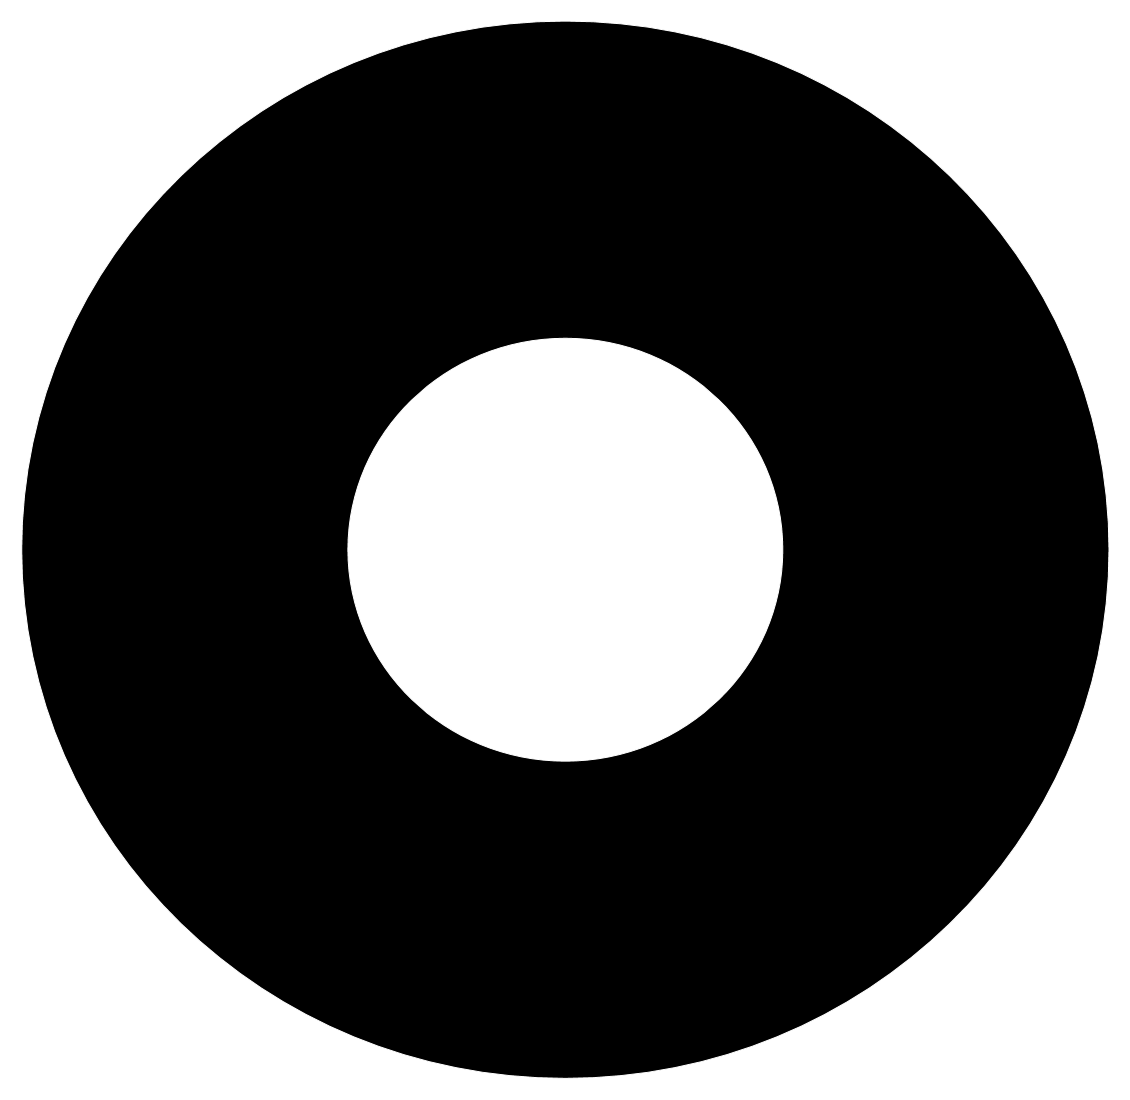

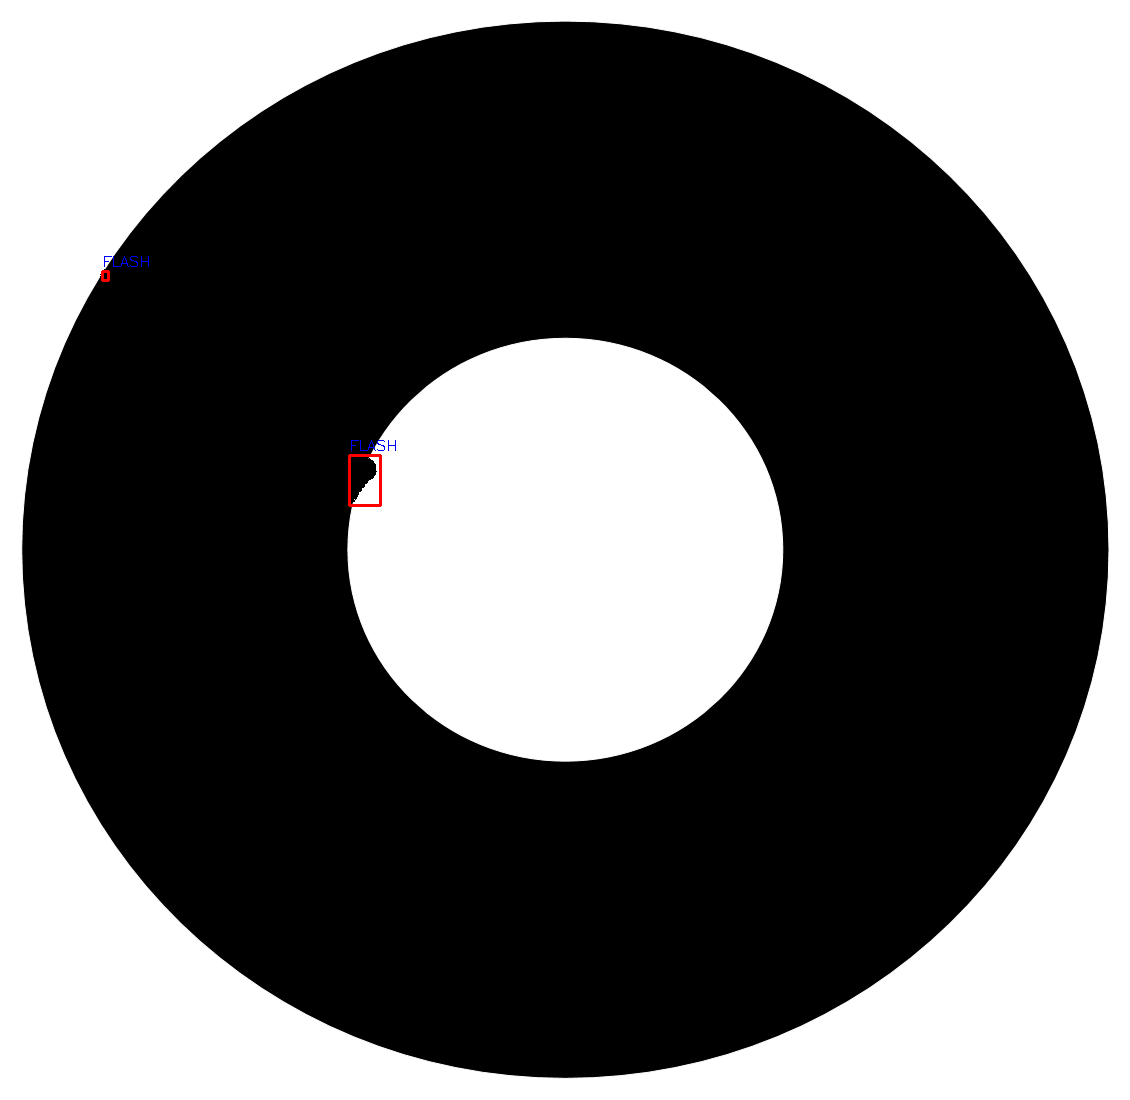

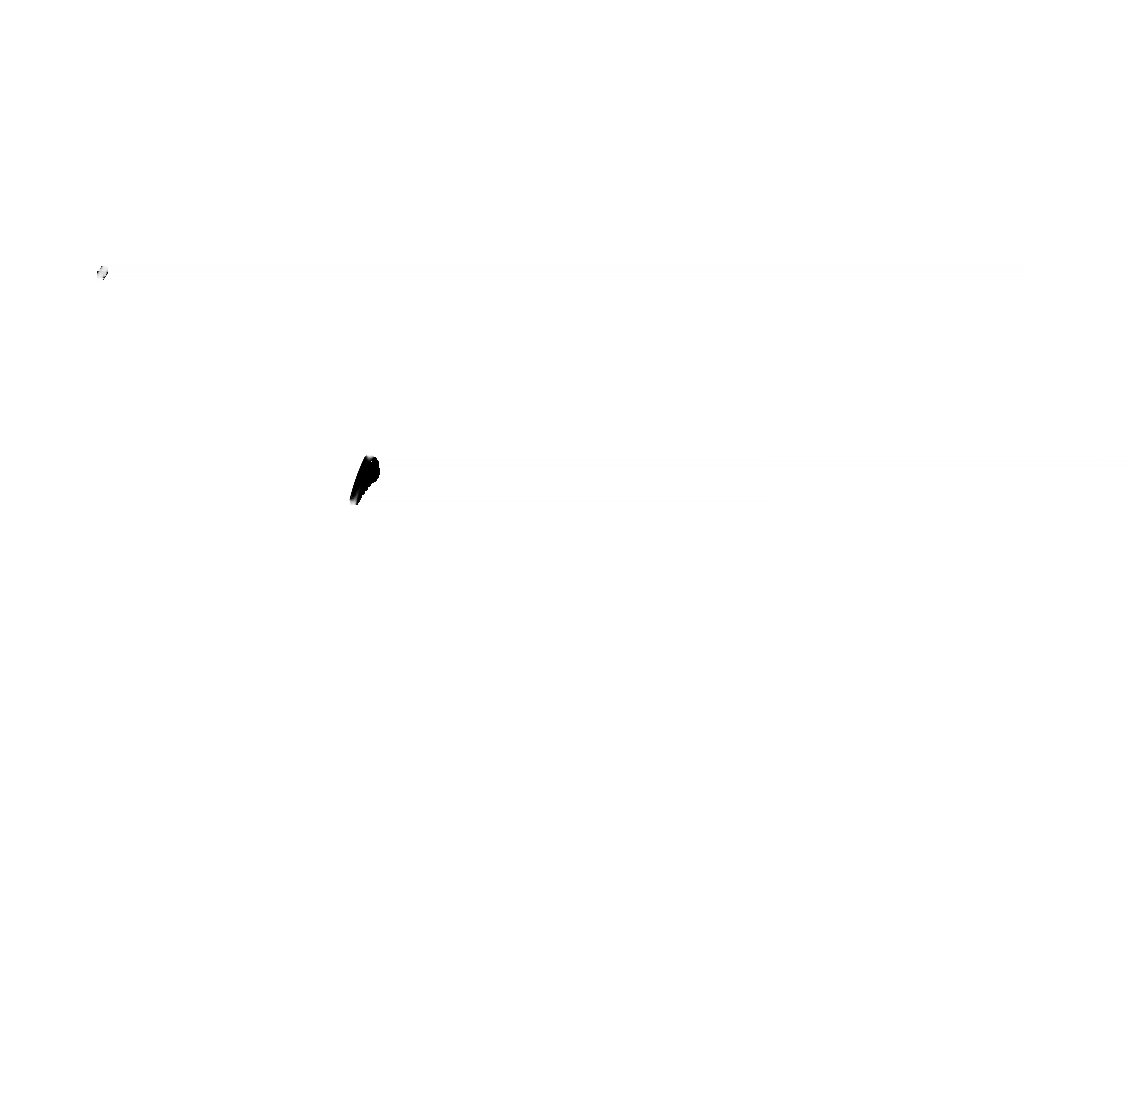

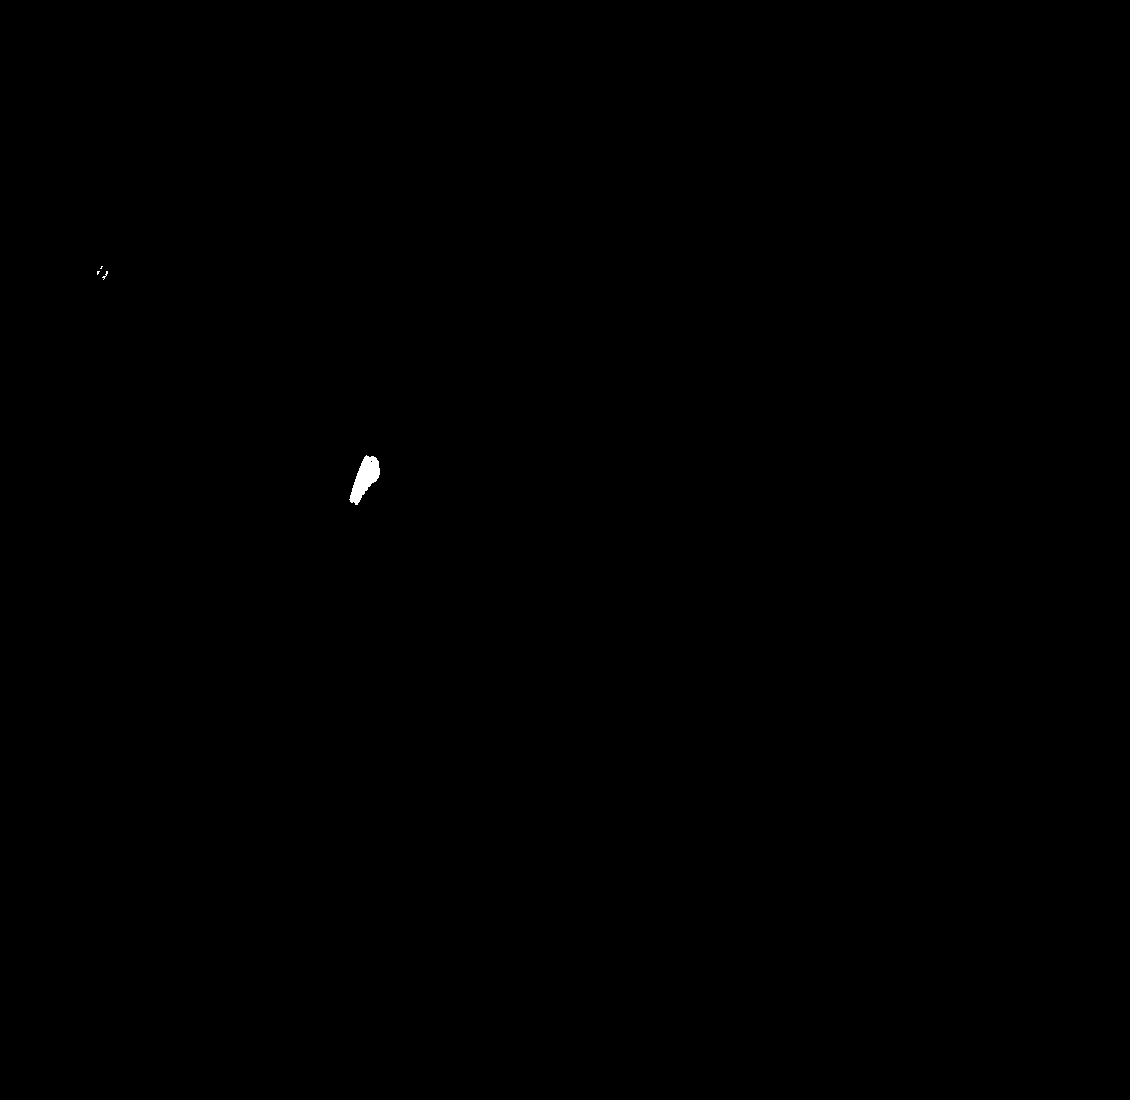

defect2.png → SSIM: 0.9994,Result: DEFECT DETECTED, Defects: ['CUT']


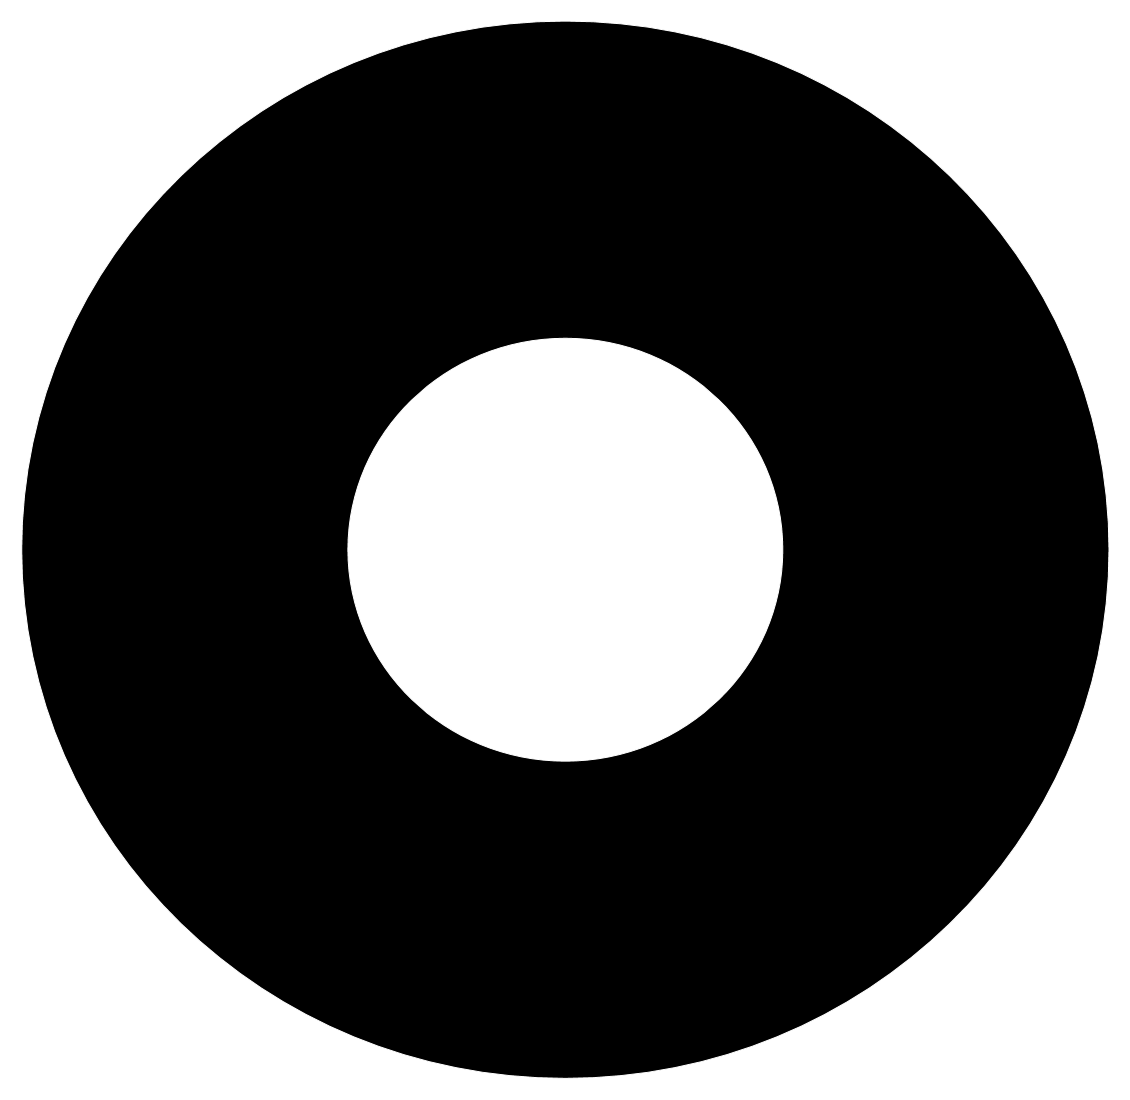

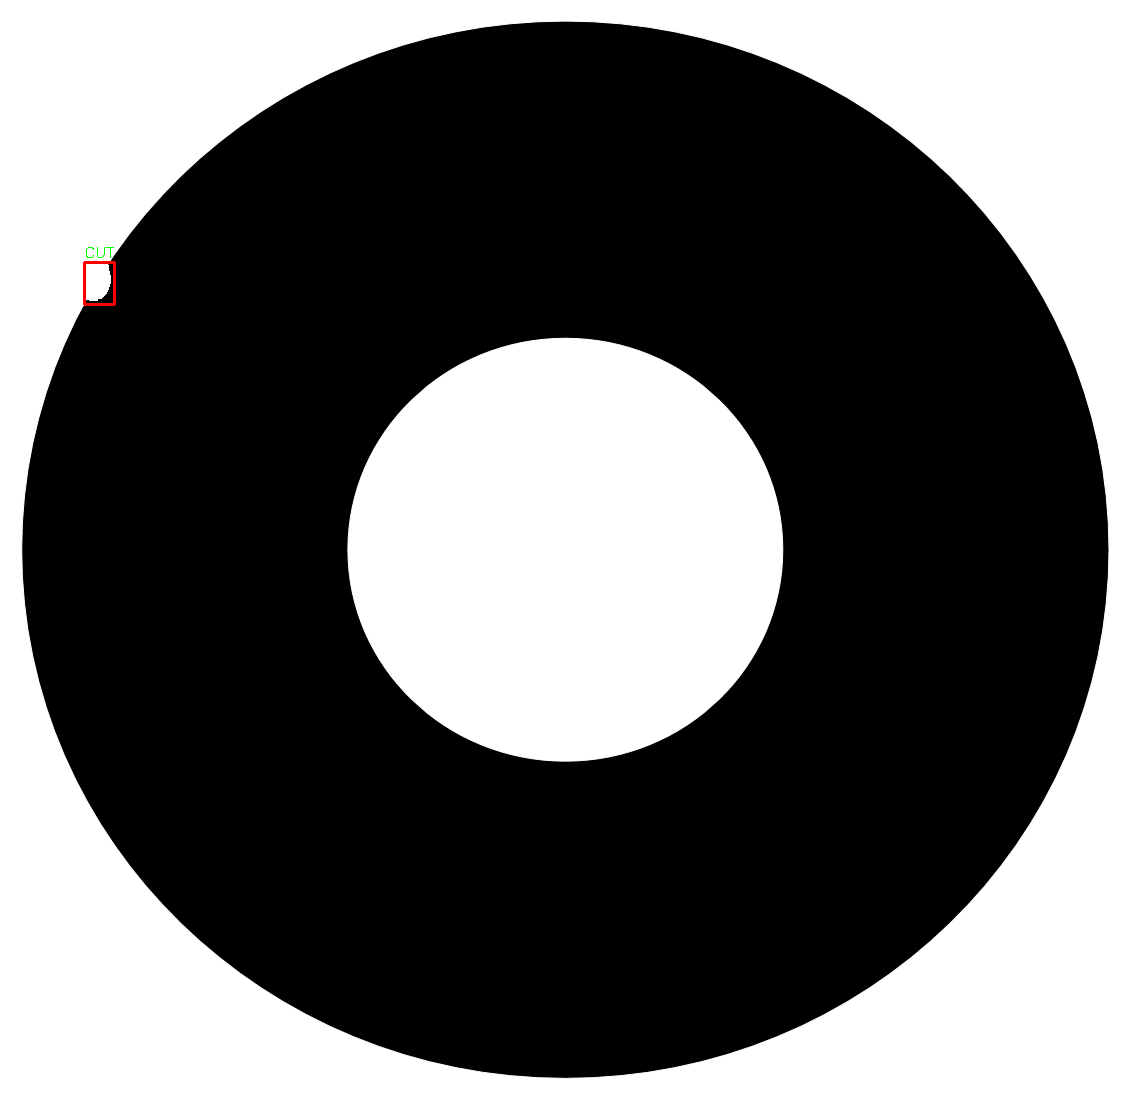

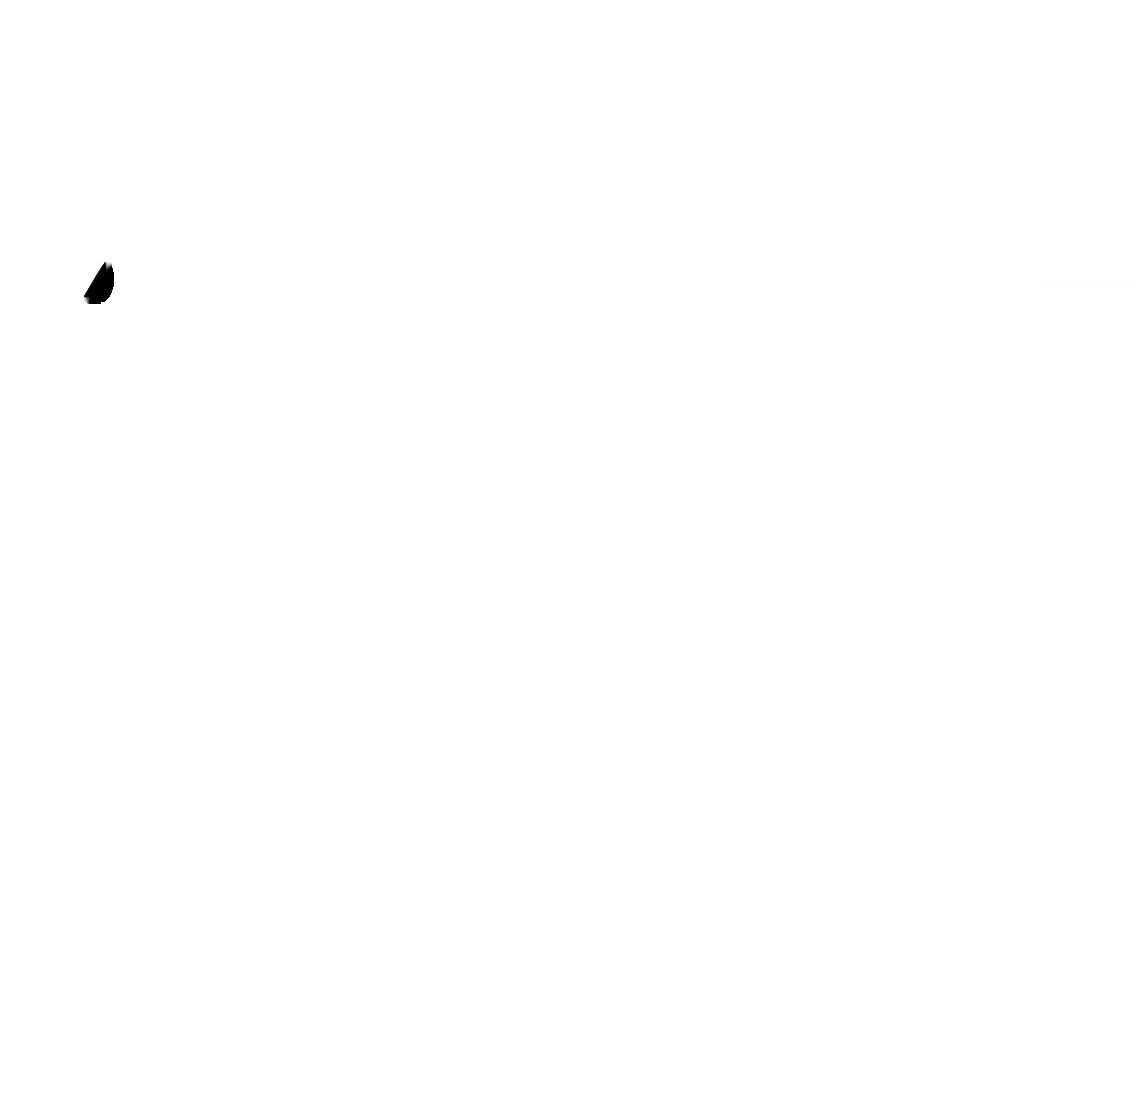

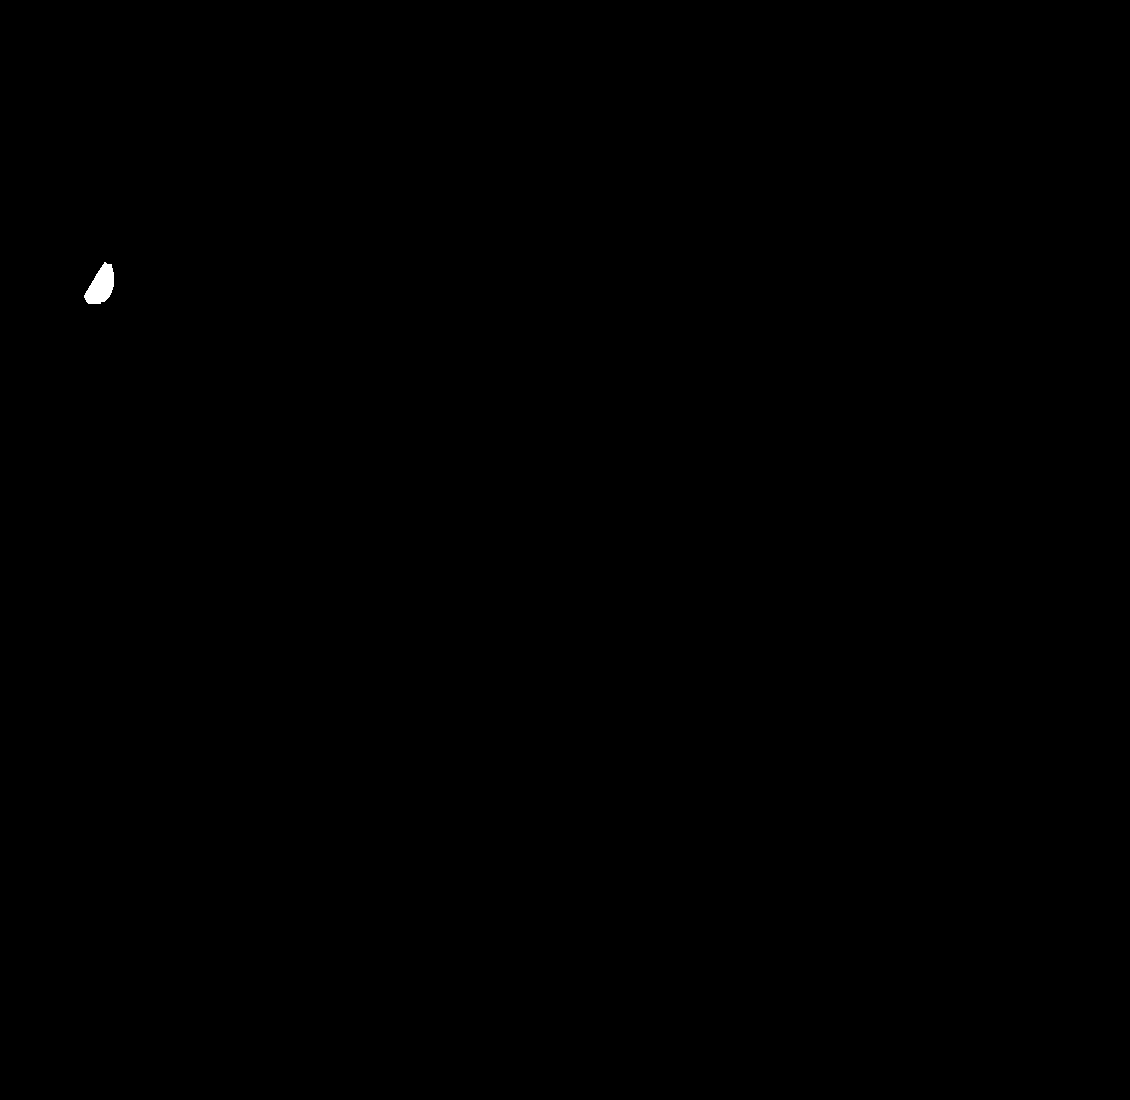

defect3.png → SSIM: 0.9993,Result: DEFECT DETECTED, Defects: ['CUT']


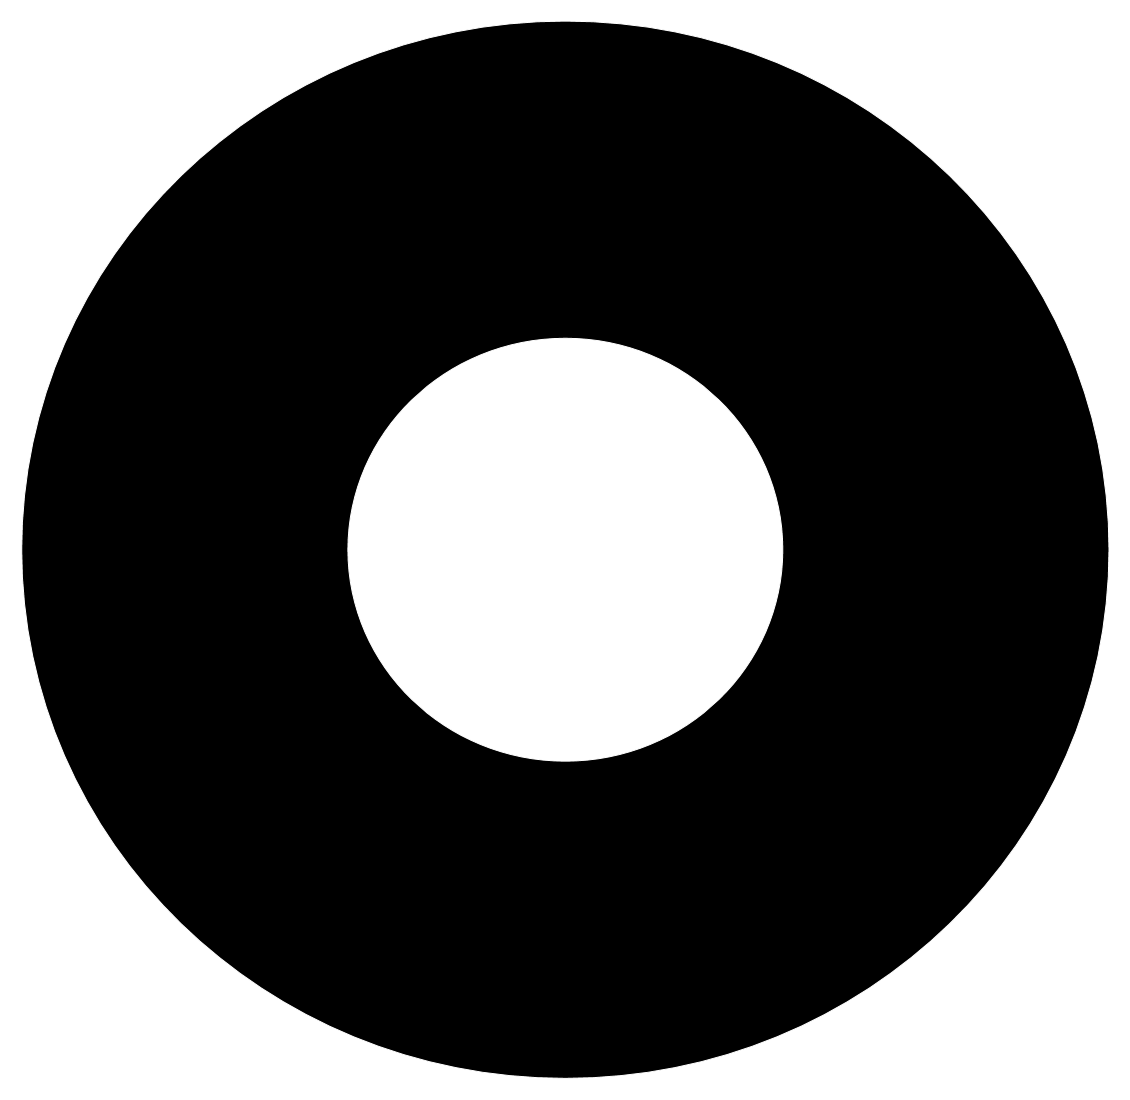

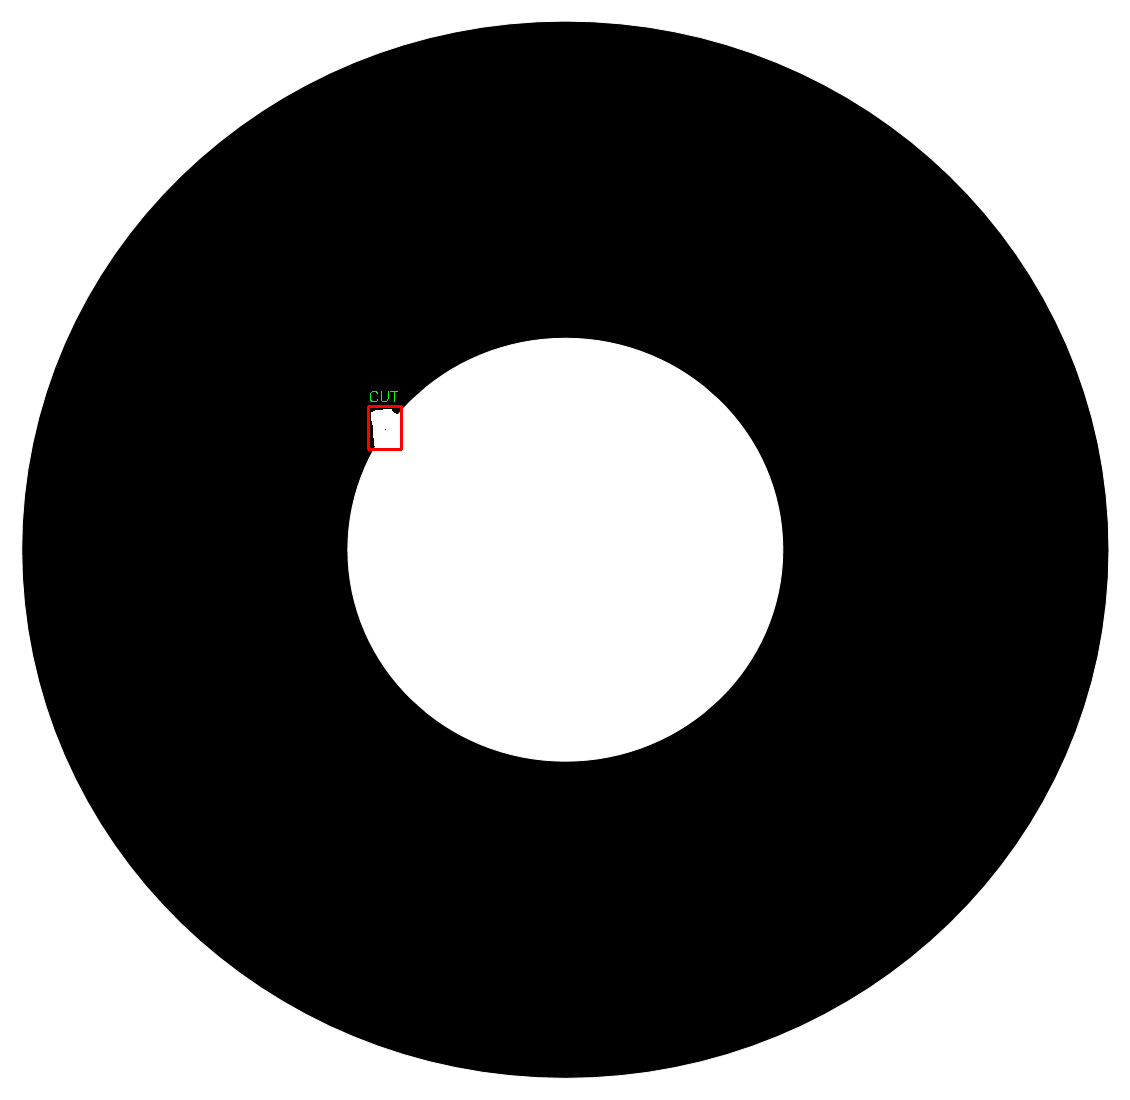

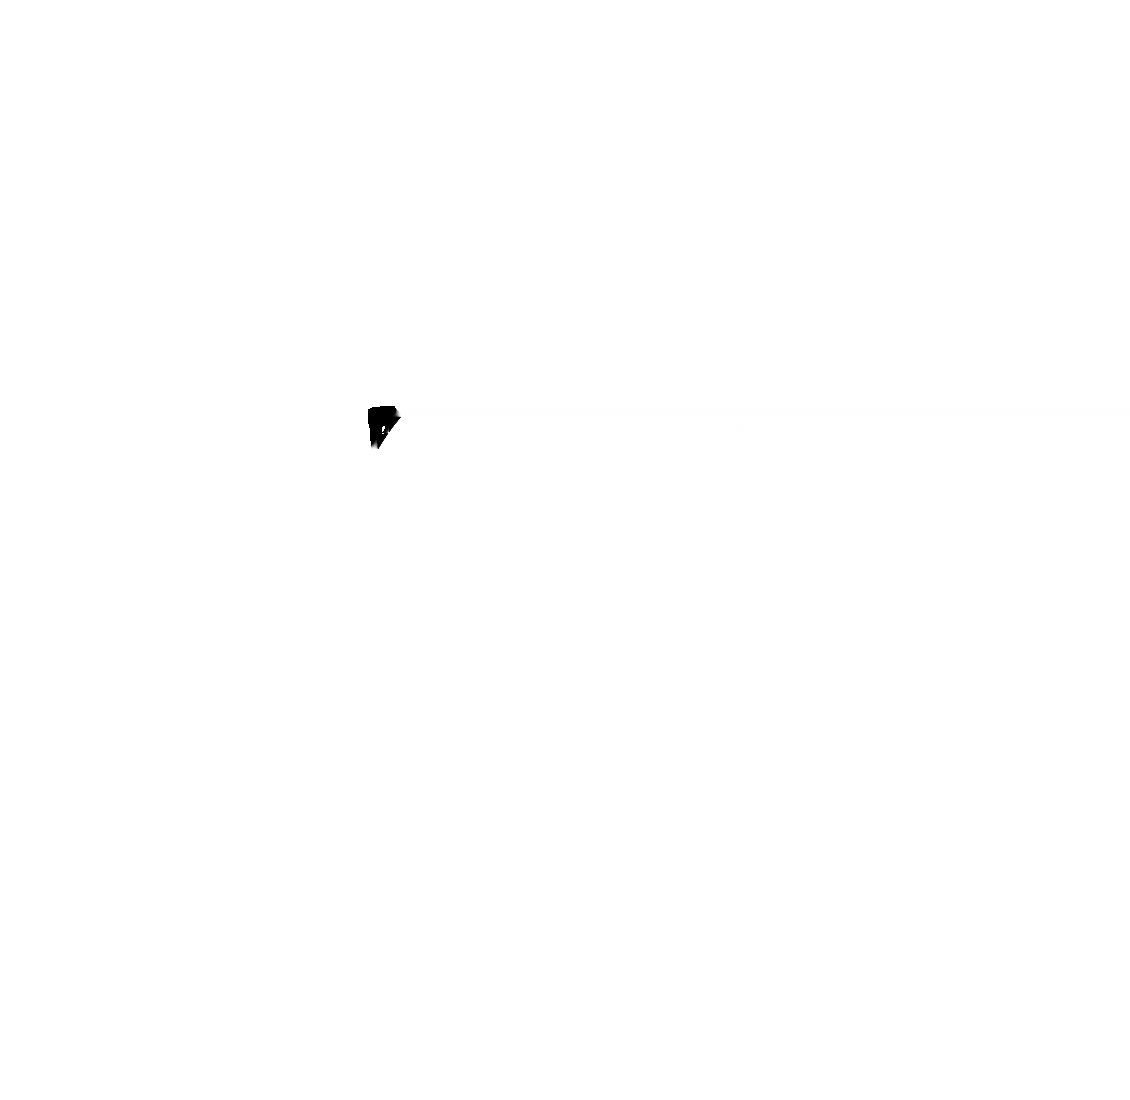

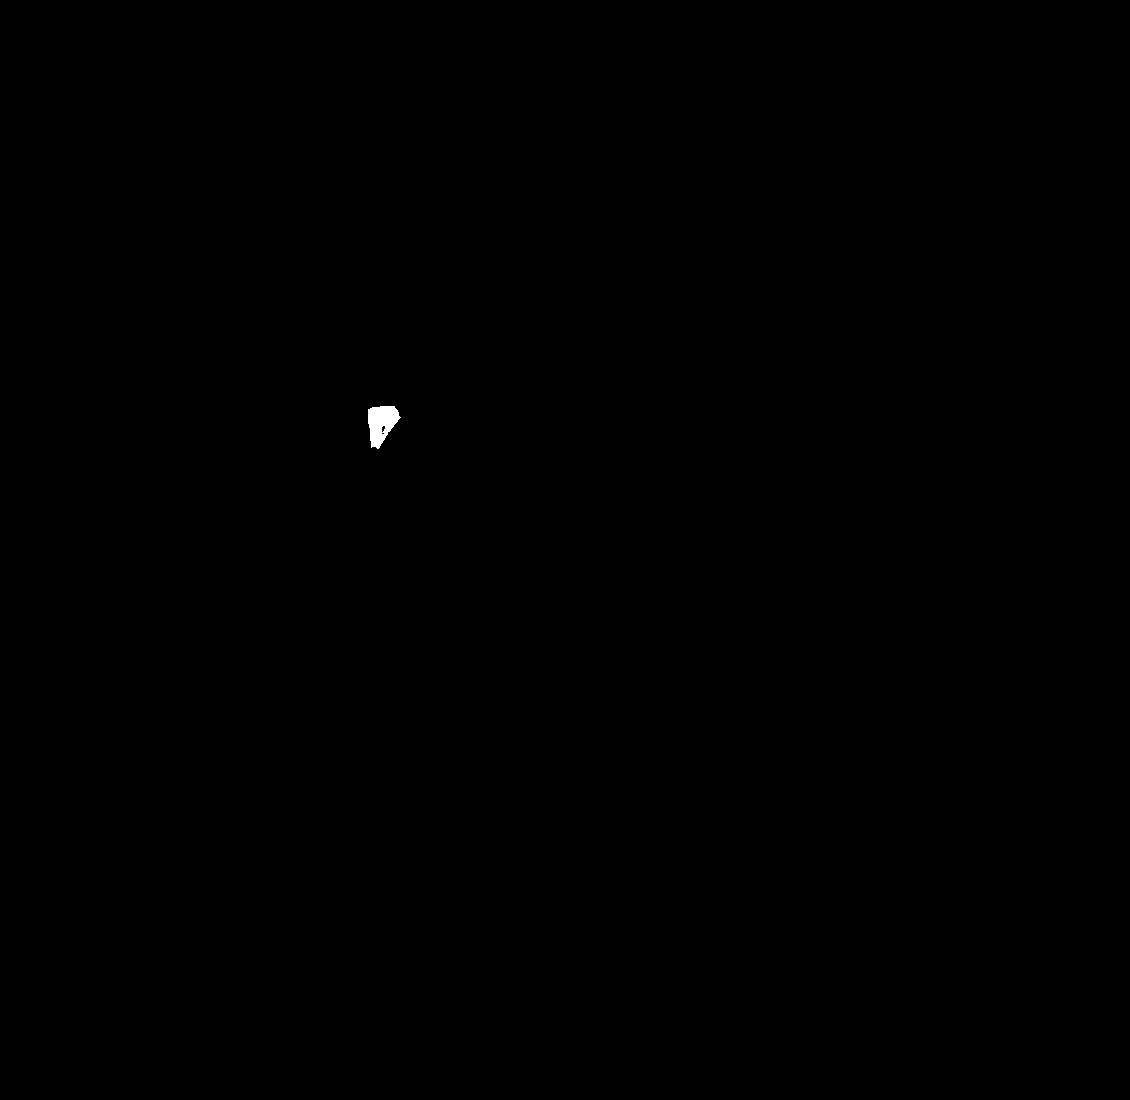

defect4.png → SSIM: 0.9993,Result: DEFECT DETECTED, Defects: ['FLASH']


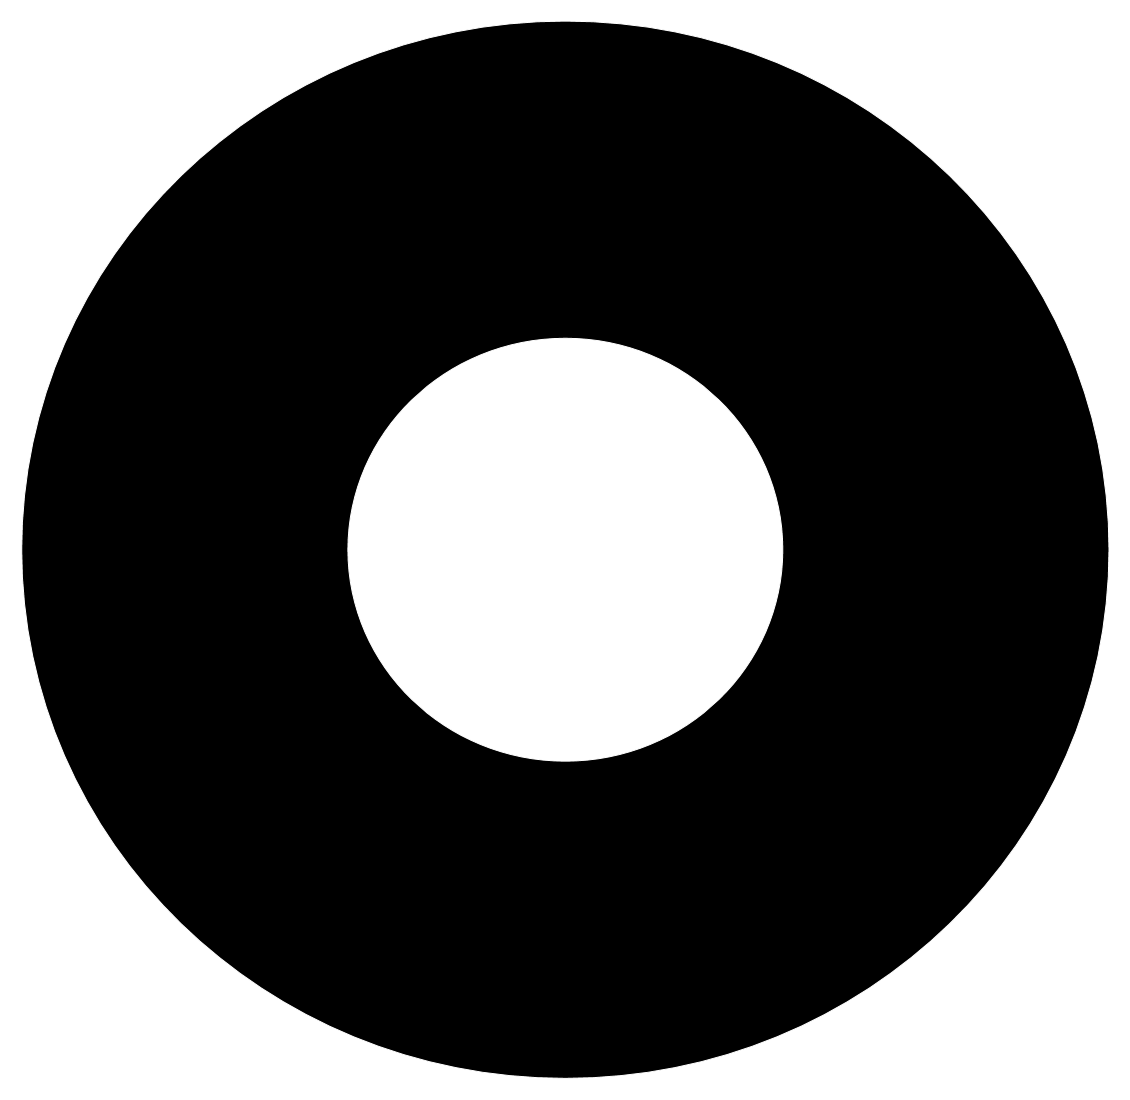

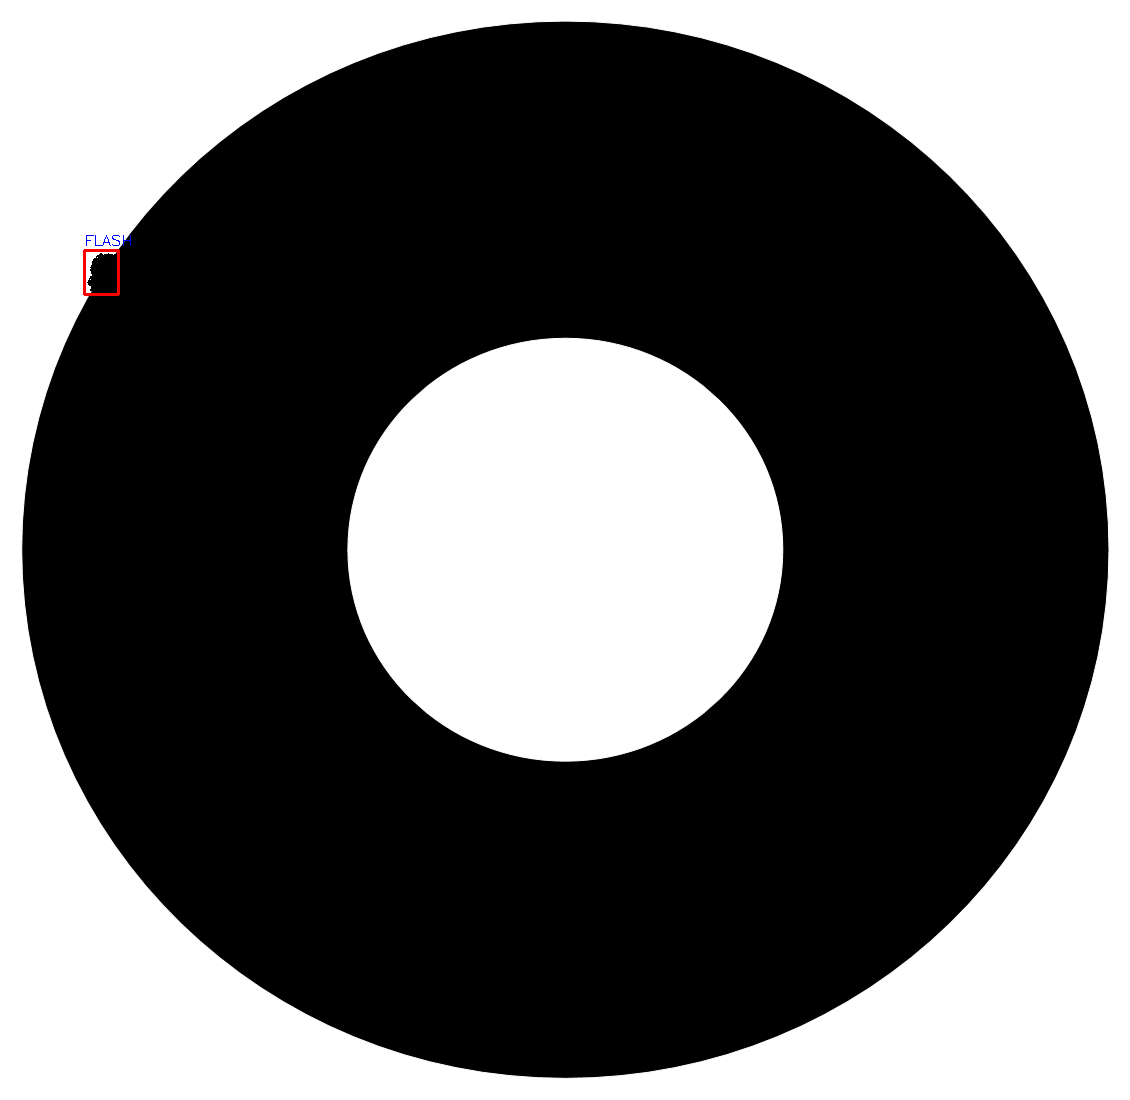

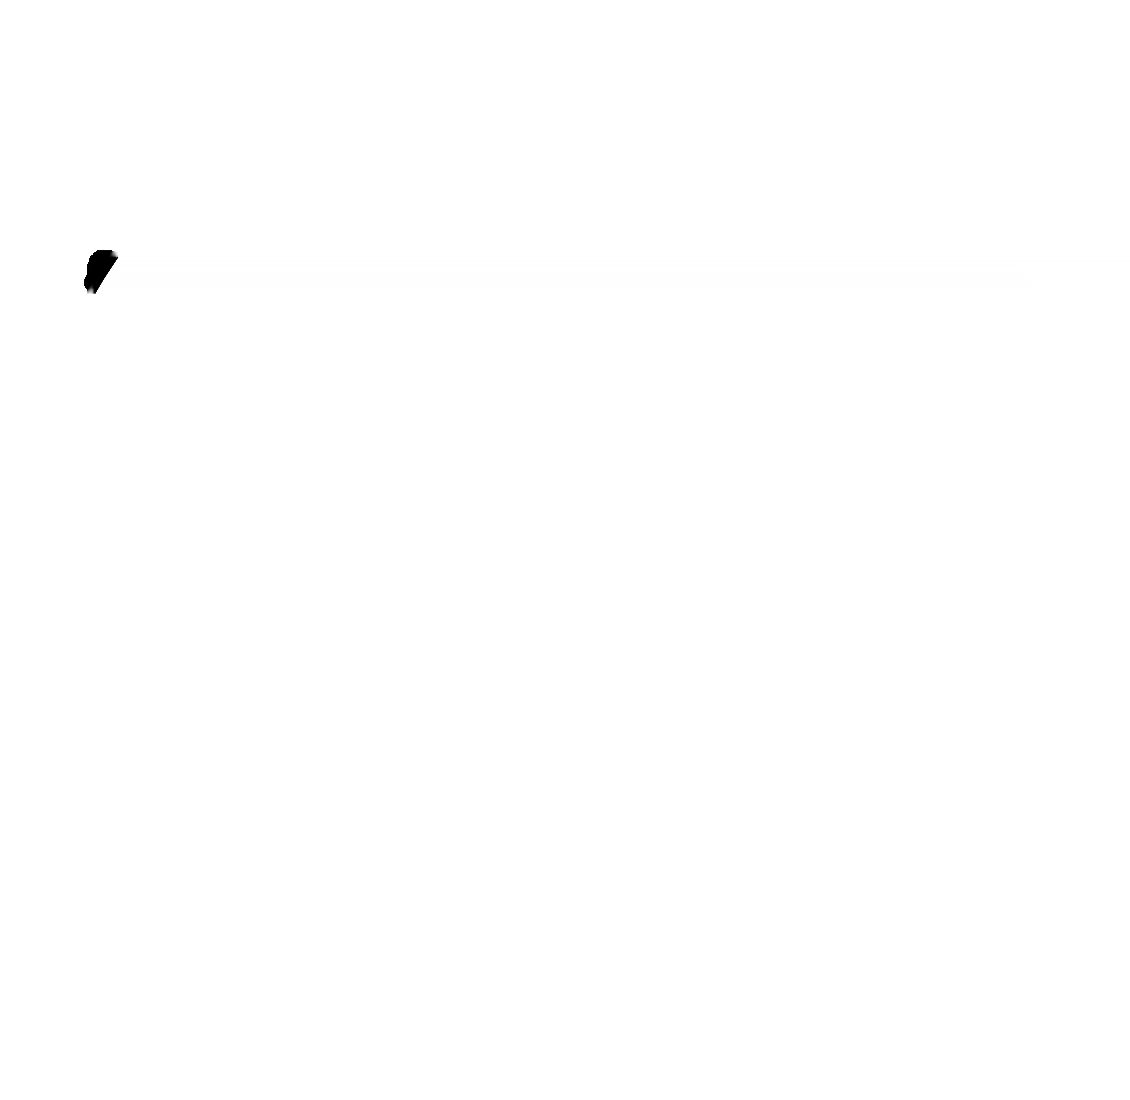

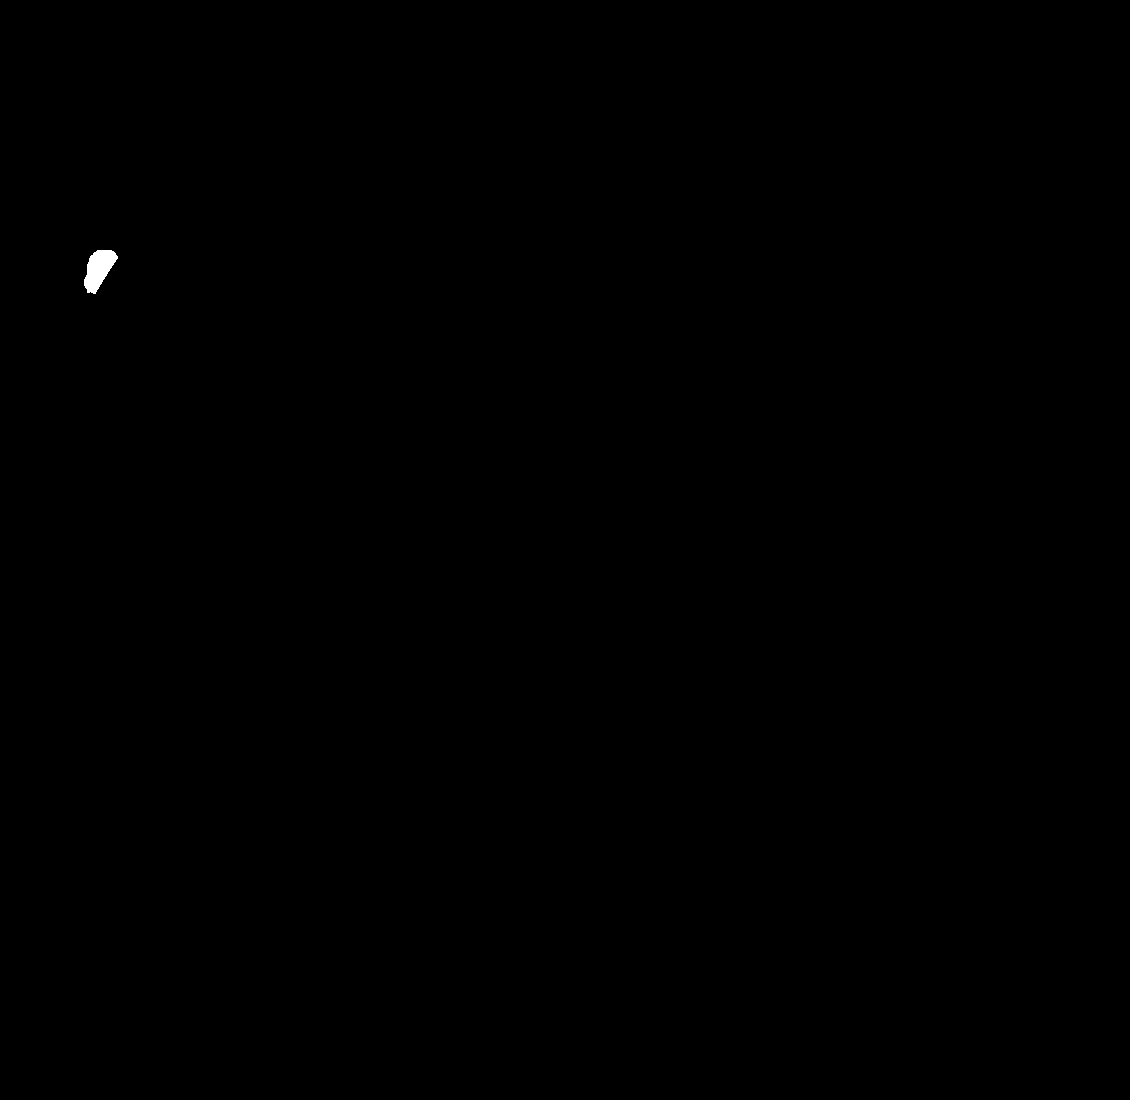

In [8]:
if __name__ == "__main__":
    reference_image_path = "good.png"
    test_images = ["defect1.png", "defect2.png", "defect3.png", "defect4.png"]

    for img_path in test_images:
        ref, test = load_images(reference_image_path, img_path)
        aligned = align_images(ref, test)
        score, defects, annotated, diff, thresh, result = detect_defects(ref, aligned)

        print(f"{img_path} → SSIM: {score:.4f},Result: {result}, Defects: {defects}")
        visualize_results(ref, annotated, diff, thresh)